# Import

In [1]:
from tensorflow.keras import utils
import os
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
%matplotlib inline

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler # transform categorical value

# Дабы код не останавливался если будут ошибки
import warnings
warnings.filterwarnings('ignore')

In [2]:
ds_path = 'E:/Documents/Data Science Pro/11 - NN/audio_ds/'
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
genres

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [3]:
def get_features(y, sr):
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr)) # хромограмма 
    # https://stackoverflow.com/questions/59027941/sound-feature-attributeerror-rmse
    # rmse = np.mean(librosa.feature.rmse(y=y, sr=sr)) # RMSE
    rmse = np.mean(librosa.feature.rms(y=y)) # RMSE
    spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) # спектральный центроид
    spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)) # 
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)) # пересечение с нулем
    # zcr = np.mean(librosa.feature.zero_crossing_rate(y=y, sr=sr)) # пересечение со значением
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=y)) # пересечение со значением
    mfcc = librosa.feature.mfcc(y=y, sr=sr) # частота цветность
    
    out = [chroma_stft, rmse, spec_cent, spec_bw, rolloff, zcr]
    for e in mfcc:
        out.append(np.mean(e))
    
    return out

# Data preparing

In [4]:
X_train = []
Y_train = []

for i in range(len(genres)):
    g = genres[i]
    for filename in os.listdir(f'{ds_path}/genres/{g}'):
        songname = f'{ds_path}/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        out=get_features(y, sr)
        
        X_train.append(out)
        Y_train.append(utils.to_categorical(i, len(genres)))
    print('Жанр', g, 'готов')

X_train = np.array(X_train)
Y_train = np.array(Y_train)
    

Жанр blues готов
Жанр classical готов
Жанр country готов
Жанр disco готов
Жанр hiphop готов
Жанр jazz готов
Жанр metal готов
Жанр pop готов
Жанр reggae готов
Жанр rock готов


In [5]:
X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()

In [6]:
y_train_class = np.argmax(Y_train, axis=1)

In [7]:
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(1000, 26)
(1000, 10)
(1000,)


In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(np.array(X_train, dtype=float))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_train, 
                                                    y_train_class, 
                                                    test_size=0.1)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(900, 26)
(100, 26)
(900,)
(100,)


# Neural Network

Epoch 1/100
45/45 [==============================] - 1s 6ms/step - loss: 2.0693 - accuracy: 0.2489 - val_loss: 1.7907 - val_accuracy: 0.3700
Epoch 2/100
45/45 [==============================] - 0s 3ms/step - loss: 1.7644 - accuracy: 0.3822 - val_loss: 1.6194 - val_accuracy: 0.4200
Epoch 3/100
45/45 [==============================] - 0s 3ms/step - loss: 1.6204 - accuracy: 0.4367 - val_loss: 1.5316 - val_accuracy: 0.4600
Epoch 4/100
45/45 [==============================] - 0s 3ms/step - loss: 1.5260 - accuracy: 0.4744 - val_loss: 1.4525 - val_accuracy: 0.4900
Epoch 5/100
45/45 [==============================] - 0s 3ms/step - loss: 1.4591 - accuracy: 0.4956 - val_loss: 1.4076 - val_accuracy: 0.5100
Epoch 6/100
45/45 [==============================] - 0s 3ms/step - loss: 1.4001 - accuracy: 0.5156 - val_loss: 1.3660 - val_accuracy: 0.5100
Epoch 7/100
45/45 [==============================] - 0s 3ms/step - loss: 1.3524 - accuracy: 0.5378 - val_loss: 1.3233 - val_accuracy: 0.5600
Epoch 8/100
4

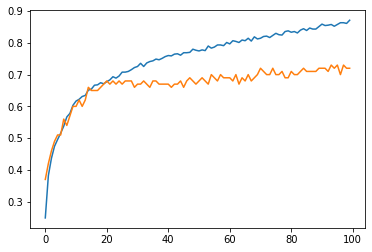

In [12]:
indexes = range(0, 26)

# Create a model
model = Sequential()

model.add(Dense(256, activation='elu', input_shape=(len(indexes), )))
model.add(Dense(128, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(32, activation='elu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(lr=1e-4), 
              metrics=['accuracy'])


history=model.fit(X_train,
                  y_train,
                  batch_size=20,
                  epochs=100,
                  validation_data=(X_test, y_test))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()